# Introduction to reproducibility and power issues

## Some Definitions 

* $H_0$ : null hypothesis: The hypotheis that the effect we are testing for is null

* $H_A$ : alternative hypothesis : Not $H_0$, so there is some signal

* $T$ : The random variable that takes value "significant" or "not significant"

* $T_S$ : Value of T when test is significant (eg $T = T_S$)

* $T_N$ : Value of T when test is not significant (eg $T = T_N$)

* $\alpha$ : false positive rate - probability to reject $H_0$ when $H_0$ is true (therefore $H_A$ is false)

* $\beta$ : false negative rate - probability to accept $H_0$ when $H_A$ is true (i.e. $H_0$ is false)


power = $1-\beta$ 

where $\beta$ is the risk of *false negative*

So, to compute power, *we need to know what is the risk of false negative*, ie, the risk to not show a significant effect while we have some signal (null is false).

In [17]:
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as sst

In [18]:
from sympy import symbols, Eq, solve, simplify, lambdify, init_printing, latex
init_printing(use_latex=True, order='old')

In [19]:
from IPython.display import HTML
# Code to make HTML for a probability table
def association_table(assocs, title):
    latexed = {'title': title}
    for key, value in assocs.items():
        latexed[key] = latex(value)
    latexed['s_total'] = latex(assocs['t_s'] + assocs['f_s'])
    latexed['ns_total'] = latex(assocs['t_ns'] + assocs['f_ns'])
    return """<h3>{title}</h3>
              <TABLE><TR><TH>$H/T$<TH>$T_S$<TH>$T_N$
              <TR><TH>$H_A$<TD>${t_s}$<TD>${t_ns}$
              <TR><TH>$H_0$<TD>${f_s}$<TD>${f_ns}$
              <TR><TH>Total<TD>${s_total}$<TD>${ns_total}$
              </TABLE>""".format(**latexed)

In [20]:
from sympy.abc import alpha, beta # get alpha, beta symbolic variables
assoc = dict(t_s = 1 - beta, # H_A true, test significant = true positives
             t_ns = beta, # true, not significant = false negatives
             f_s = alpha, # false, significant = false positives
             f_ns = 1 - alpha) # false, not sigificant = true negatives
HTML(association_table(assoc, 'Not considering prior'))

## How do we compute power ? 

### What is the effect ?


$$\hspace{3cm}\mu = \mu_1 - \mu_2$$

### What is the standardized effect ? (eg Cohen's d)

$$\hspace{3cm}d = \frac{\mu_1 - \mu_2}{\sigma} = \frac{\mu}{\sigma}$$

### "Z" : Effect accounting for the sample size 

$$\hspace{3cm}Z = \frac{\mu}{\sigma / \sqrt{n}}$$

### Cohen's d value:

In [21]:
# print some cohen values
# %pylab inline
muse = (.05, .1,.2,.3,.4,.5);
sigmas = np.linspace(1.,.5,len(muse))
cohenstr = ["For sigma = %3.2f and m = %3.2f Cohen d = %3.2f" %(sig,mu,coh) 
       for (sig,mu,coh) in zip(sigmas,muse, np.asarray(muse)/sigmas)]
for s in cohenstr:
    print(s)

For sigma = 1.00 and m = 0.05 Cohen d = 0.05
For sigma = 0.90 and m = 0.10 Cohen d = 0.11
For sigma = 0.80 and m = 0.20 Cohen d = 0.25
For sigma = 0.70 and m = 0.30 Cohen d = 0.43
For sigma = 0.60 and m = 0.40 Cohen d = 0.67
For sigma = 0.50 and m = 0.50 Cohen d = 1.00


We have to estimate the effect $\mu$, say under some normal noise. Our statistic will be:

$$
t = \frac{\hat{\mu}}{\hat{\sigma_{\mu}}} = \frac{\hat{\mu}}{\hat{{SE}_{\mu}}}
$$

Power is the probability that the observed t is greater than $t_{.05}$, computing $t_{.05}$ by assuming that we are under the null. 

So, we compute $t_{.05}$, and want to compute $P(t > t_{.05})$. 

To compute this, __we need the distribution of our measured t - therefore we need to know the signal / effect size !__ 

Let's assume we know this and call it $t_{nc}$, and $F_{nc}$ for the cumulative distribution (more on this in the appendix).

$\mbox{Power} = 1 - \beta =  P(t > t_{.05}) = 1 - F_{nc}(t_{.05})$


__This power will depend on 4 parameters :__

$$ \mbox{The non standardized effect : } \mu$$

$$\mbox{The standard deviation of the data : } \sigma$$

$$\mbox{The number of subjects : } n$$

$$\mbox{The type I risk of error : } \alpha$$

And on the distribution of the statistic under the alternative hypothesis. Here, we assume our original data are normals, and the $t = \frac{\hat{\mu}}{\hat{{SE}_{\mu}}}$ statistics follows a non central t distribution with non centrality parameter 

$$\theta = \mu \sqrt{n}/\sigma$$

and $n-1$ degrees of freedom. 

### What is the effect size of APOE on the hippocampal volume ?


Authors find p value of 6.63e-10

They had 733 subjects

In [6]:
n01 = sst.norm(0,1.)
z = n01.isf(6.6311e-10)
d = n01.isf(6.6311e-10)/np.sqrt(733)
print("z = %4.3f d = %4.3f " %(z,d))

z = 6.064 d = 0.224 


In [22]:
import scipy.stats as sst
import numpy as np
import matplotlib.pyplot as plt


In [23]:
# plot power as a function of n : define a little function that 
# takes n, mu, sigma, alpha, and report n. 
# Optionally plot power as a function of nfrom matplotlib.patches import Polygon


def stat_power(n=16, mu=1., sigma=1., alpha=0.05):
    """
    This function computes the statistical power of an analysis assuming a normal
    distribution of the data with a one sample t-test
    
    Parameters:
    -----------
    n: int,
        The number of sample in the experiment
    mu: float
        The mean of the alternative
    sigma: float
        The standard deviation of the alternative
    plot: bool
        Plot something
    alpha: float
        The risk of error (type I)
    
    Returns:
    --------
    float
        The statistical power for this number of sample, mu, sigma, alpha
    """
    df = n-1
    theta = np.sqrt(n)*mu/sigma    
    t_alph_null = sst.t.isf(alpha, df)
    ncrv = sst.nct(df, theta)
    spow = 1 - ncrv.cdf(t_alph_null)

    return spow


In [24]:
from matplotlib.patches import Polygon

def plot_power(n=16, mu=1., sigma=1., alpha=0.05, xlen=500):
    """
    n: int
        sample size
    mu: float
        effect size
    sigma: float
        noise standard deviation
    alpha: float
        type I error
        
    """
    df = n # n-1
    theta = np.sqrt(n)*mu/sigma
    ncrv = sst.nct(df, theta)
    t_alph_null = sst.t.isf(alpha, df)
    spow = 1 - ncrv.cdf(t_alph_null)

    
    # define the domain of the plot
    norv = sst.norm(0, 1.)
    bornesnc = ncrv.isf([0.001, .999])
    bornesn = norv.isf([0.001, .999])
    
    # because the nc t will have higher max borne, and the H0 normal will be on the left
    x = np.linspace(np.min(bornesn), np.max(bornesnc), xlen)
    t_line = np.zeros_like(x)
    
    # define the line 
    x_t_line = np.argmin((x-t_alph_null)**2)
    y_t_line = np.max(np.hstack((ncrv.pdf(x), norv.pdf(x))))
    t_line[x_t_line] = y_t_line

    fig, ax = plt.subplots()
    plt.plot(x, ncrv.pdf(x), 'g', x, norv.pdf(x), 'b', x, t_line, 'r')
        
    # Make the shaded region
    # http://matplotlib.org/xkcd/examples/showcase/integral_demo.html
    a = x[x_t_line]; b =  np.max(bornesnc);
    ix = np.linspace(a,b)
    iy = ncrv.pdf(ix)
    verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
    poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
    ax.add_patch(poly)
        
    ax.set_xlabel("t-value - H1 centred on " + r"$\theta $" + " = %4.2f;  " %theta 
                      + r"$\mu$" + " = %4.2f" %mu); 
    ax.set_ylabel("Probability(t)");
    ax.set_title('H0 and H1 sampling densities ' 
                     + r'$\beta$' + '= %3.2f' %spow + ' n = %d' %n)
    plt.show()


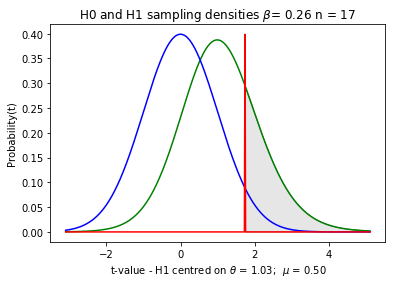

Power =  0.25543571930457243       Z effect (Non centrality parameter) =  1.0307764064044151


In [10]:
n = 17
mu = .5
sigma = 2.
pwr = stat_power(n, mu, sigma, alpha=0.05)
plot_power(n, mu, sigma, alpha=0.05, xlen=500)

print ("Power = ", pwr, "      Z effect (Non centrality parameter) = ", mu*np.sqrt(n)/sigma)

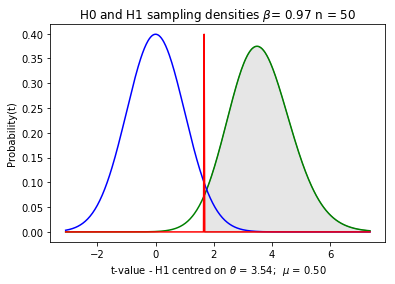

Power =  0.9672067362842243       Z effect (Non centrality parameter):  3.5355339059327378


In [11]:
n = 50
mu = .5
sigma = 1.
pwr = stat_power(n, mu, sigma, alpha=0.05)
plot_power(n, mu, sigma, alpha=0.05, xlen=500)

print("Power = ", pwr, "      Z effect (Non centrality parameter): ", mu*np.sqrt(n)/sigma)

### Plot power as a function of the number of subject in the study

In [12]:
# 

def pwr_funcofsubj(muse, nses, alpha=.05, sigma=1):
    """
    Function to plot power as a function of the number of subjects (the nses) 
    for an array of effect size (muses)
    
    muse: array of float 
          The effect sizes : mu
    nses: array of integer
          The number of subjects
    alpha: float, 
          type I risk
    sigma: float, 
          data sigma
    """
    mstr = [ 'd='+str(m) for m in np.asarray(muse)/sigma]
    lines=[]
    for mu in (muse):
        pw = [stat_power(n, mu, sigma, alpha=alpha) for n in nses]    
        (pl,) = plt.plot(nses, pw)
        lines.append(pl)
    plt.legend( lines, mstr, loc='upper right', shadow=True)
    plt.xlabel(" Number of subjects ")
    plt.ylabel(" Power ");
    
    return None


### **** For a small number of subjects ****

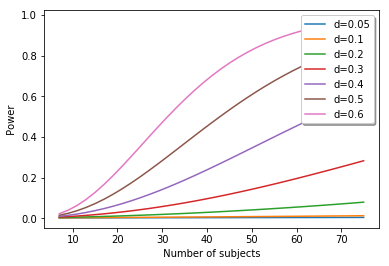

In [13]:
mus = (.05, .1,.2,.3,.4,.5, .6);
#nse = range(70, 770, 20)
nse = range(7, 77, 2)
alph = 1.e-3
    
pwr_funcofsubj(mus, nse, alph)

### **** For a larger number of subjects ****

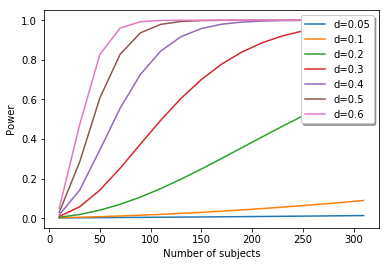

In [14]:
mus = (.05,.1,.2,.3,.4,.5,.6);
nse = range(10, 330, 20)
#nse = range(7, 77, 2)
alph = 0.001
    
pwr_funcofsubj(mus, nse, alph)

### Here - stricter $\alpha$

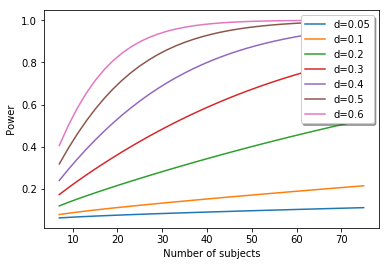

In [15]:
mus = (.05, .1,.2,.3,.4,.5, .6);
#nse = range(10, 770, 20)
nse = range(7, 77, 2)
alph = 0.05/30000
alph = 0.05
    
pwr_funcofsubj(mus, nse, alph)

In [16]:
#Example: 
n = 259; mu= 230; sigma = 1487
stat_power(n, mu, sigma, alpha=0.05)